<a href="https://colab.research.google.com/github/dhillonarman/Topsis-_Pretrained_Model_Armandeep_102216076/blob/main/102216076_topsis_pretrainedmodel_textgeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Evaluating GPT-2...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Run 1: Once upon a time, I had only felt a little of a thrill on the idea of using my father as an informant. A little over a decade ago, his father worked at the Drug Enforcement Administration, after his wife, the doctor in chief,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Run 2: Once upon a time, they may look like this, but there's nothing much. This is not real science. There's no "science" at all. In the abstract. I'll tell you everything else. How do we know that the earth


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Run 3: Once upon a time, you would be a child of Satan, or not at all of them, but for a young man of yours like me and your whole company. You have been a disciple of the devil, and there are many things to be


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Run 4: Once upon a time, when we were about twenty hundred and sixty-five years old, these white things took hold of the heart of man. That which we might call the light of life, the divine light which gives up hope, or the universal
Run 5: Once upon a time, when such an event was not expected, we were given a second chance... we are free to do what is best for our good as long as our rights are respected and our ideas are supported. -Dr. Alberts

Evaluating XLNet...
Run 1: Once upon a time,--- -- to to to or to to a to to  to to from to or from to to an to to cause to to in or to from from to from in to to the to or
Run 2: Once upon a time,--- --... -  -.- — -, - that - and - such-- that---- I-- First-
Run 3: Once upon a time,--- --.--, - .- , . -. . and . it, , it, it-- it, and , forth-
Run 4: Once upon a time, should or should or or should should or seam or seam whether or or or seam at seam or or no seam or anything or seam press seam or whether or seam seam seam to seam seam or pr

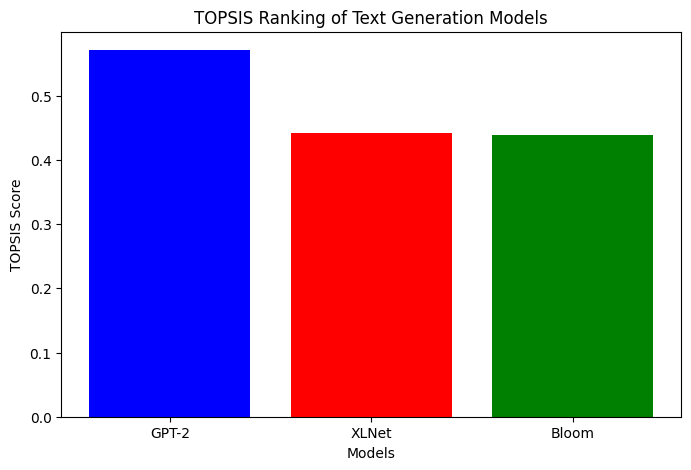

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import time
from math import exp

from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer

def compute_perplexity(model, tokenizer, texts):
    """Compute perplexity for causal models."""
    model.eval()
    losses = []
    with torch.no_grad():
        for text in texts:
            if len(text.strip()) == 0:
                continue
            encodings = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
            input_ids = encodings.input_ids
            outputs = model(input_ids, labels=input_ids)
            loss = outputs.loss
            losses.append(loss.item())
    return exp(np.mean(losses)) if losses else float('inf')

def compute_diversity(generated_texts):
    """Diversity: unique tokens ratio."""
    all_tokens = [word for text in generated_texts for word in text.split()]
    return len(set(all_tokens)) / (len(all_tokens) + 1e-5)

dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
eval_texts = dataset["text"][:100]

prompt_text = "Once upon a time,"

gen_kwargs_causal = {
    "max_length": 50,
    "do_sample": True,
    "num_return_sequences": 1,
    "no_repeat_ngram_size": 2
}

gen_kwargs_xlnet = {
    "max_length": 50,
    "top_k": 50,
    "top_p": 0.95,
    "temperature": 0.7,
    "num_return_sequences": 1,
    "no_repeat_ngram_size": 3,
    "do_sample": True
}

models = {
    "GPT-2": {"type": "causal", "model_name": "gpt2"},
    "XLNet": {"type": "causal", "model_name": "xlnet-base-cased"},
    "Bloom": {"type": "causal", "model_name": "bigscience/bloom-560m"}
}

metrics = {}
num_generations = 5

for model_name, info in models.items():
    print(f"\nEvaluating {model_name}...")
    model = AutoModelForCausalLM.from_pretrained(info["model_name"], trust_remote_code=True)
    tokenizer = AutoTokenizer.from_pretrained(info["model_name"])

    generated_texts, gen_times = [], []

    for i in range(num_generations):
        start = time.time()
        input_ids = tokenizer(prompt_text, return_tensors="pt").input_ids
        output = model.generate(input_ids, **(gen_kwargs_xlnet if model_name == "XLNet" else gen_kwargs_causal))
        gen_text = tokenizer.decode(output[0], skip_special_tokens=True)
        elapsed = time.time() - start

        gen_times.append(elapsed)
        generated_texts.append(gen_text)
        print(f"Run {i+1}: {gen_text}")

    avg_inference_time = np.mean(gen_times)
    ppl = compute_perplexity(model, tokenizer, generated_texts)
    diversity = compute_diversity(generated_texts)

    metrics[model_name] = [ppl, diversity, avg_inference_time]

data = np.array(list(metrics.values()))

data = np.where(np.isnan(data), np.nanmean(data, axis=0, keepdims=True), data)

weights = np.array([0.3, 0.4, 0.3])
impacts = np.array(["-", "+", "-"])

norm_data = data / np.sqrt((data**2).sum(axis=0))
weighted_data = norm_data * weights

ideal_best = np.where(impacts == "+", weighted_data.max(axis=0), weighted_data.min(axis=0))
ideal_worst = np.where(impacts == "+", weighted_data.min(axis=0), weighted_data.max(axis=0))

dist_best = np.sqrt(((weighted_data - ideal_best) ** 2).sum(axis=1))
dist_worst = np.sqrt(((weighted_data - ideal_worst) ** 2).sum(axis=1))

topsis_scores = dist_worst / (dist_best + dist_worst)

results_df = pd.DataFrame({
    'Model': list(metrics.keys()),
    'Perplexity': data[:, 0],
    'Diversity': data[:, 1],
    'Inference Time (s)': data[:, 2],
    'TOPSIS Score': topsis_scores
})

results_df["Rank"] = results_df["TOPSIS Score"].rank(ascending=False, method="dense").astype(int)

print("\nEvaluation Results:")
print(results_df)

results_df.to_csv("topsis_results.csv", index=False)
print("\nResults saved to 'topsis_results.csv'.")

plt.figure(figsize=(8, 5))
plt.bar(results_df['Model'], results_df['TOPSIS Score'], color=['blue', 'red', 'green'])
plt.xlabel("Models")
plt.ylabel("TOPSIS Score")
plt.title("TOPSIS Ranking of Text Generation Models")
plt.show()
